In [2]:
import os
import boto3
import pandas as pd
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from dotenv import load_dotenv

# Load environment variables
ENV_PATH = ".env"
load_dotenv(ENV_PATH)

# Get S3 bucket and region
bucket = os.getenv("BUCKET_NAME")
session = boto3.session.Session()
region = session.region_name

print(f"Bucket: {bucket}")
print(f"Region: {region}")

# Initialize SageMaker Feature Store session
sagemaker_session = sagemaker.Session()
role = os.getenv("SAGEMAKER_ROLE")
feature_store_session = Session(
    boto_session=session,
    sagemaker_client=boto3.client('sagemaker', region_name=region),
    sagemaker_featurestore_runtime_client=boto3.client('sagemaker-featurestore-runtime', region_name=region)
)

print(f"\nSageMaker Role: {role}")
print(f"Feature Store Session initialized")


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket: mlops-backblaze-4263963c-us-east-1
Region: us-east-1

SageMaker Role: arn:aws:iam::173448391640:role/LabRole
Feature Store Session initialized


In [3]:
# Load Feature Group names from .env
feature_group_train = os.getenv("FEATURE_GROUP_TRAIN")
feature_group_val = os.getenv("FEATURE_GROUP_VAL")
feature_group_test = os.getenv("FEATURE_GROUP_TEST")
feature_group_prod = os.getenv("FEATURE_GROUP_PROD")

print("="*80)
print("FEATURE GROUP NAMES FROM .ENV")
print("="*80)
print(f"Training:     {feature_group_train}")
print(f"Validation:   {feature_group_val}")
print(f"Test:         {feature_group_test}")
print(f"Production:   {feature_group_prod}")
print("="*80)


FEATURE GROUP NAMES FROM .ENV
Training:     backblaze-hdd-failure-20260208-201907-train
Validation:   backblaze-hdd-failure-20260208-201907-validation
Test:         backblaze-hdd-failure-20260208-201907-test
Production:   backblaze-hdd-failure-20260208-201907-production


In [4]:
def load_feature_group_to_dataframe(feature_group_name, feature_store_session, use_offline_store=False):
    """
    Load a Feature Group from SageMaker Feature Store into a pandas DataFrame.
    
    Parameters:
    -----------
    feature_group_name : str
        Name of the feature group to load
    feature_store_session : sagemaker.Session
        SageMaker session for Feature Store
    use_offline_store : bool
        If True, use Athena to query offline store. If False, read from S3 parquet directly.
    
    Returns:
    --------
    pd.DataFrame : DataFrame containing all records from the feature group
    """
    import time
    from sagemaker.feature_store.feature_group import FeatureGroup
    
    print(f"\nLoading Feature Group: {feature_group_name}")
    
    # Create Feature Group object
    feature_group = FeatureGroup(
        name=feature_group_name,
        sagemaker_session=feature_store_session
    )
    
    # Check status
    try:
        description = feature_group.describe()
        status = description.get('FeatureGroupStatus')
        print(f"  Status: {status}")
        
        if status != 'Created':
            print(f"  ⚠ Warning: Feature Group is not in 'Created' state")
            return None
    except Exception as e:
        print(f"  ✗ Error: Feature Group not found - {str(e)[:100]}")
        return None
    
    if use_offline_store:
        # Use Athena query to retrieve data from offline store
        query_string = f'SELECT * FROM "{feature_group_name}"'
        
        print(f"  Querying offline store via Athena...")
        print(f"  Query: {query_string}")
        
        try:
            # Create Athena query
            athena_query = feature_group.athena_query()
            
            # Set database and table
            athena_query.run(
                query_string=query_string,
                output_location=f"s3://{bucket}/athena-results/"
            )
            
            # Wait for query to complete
            athena_query.wait()
            
            # Get results as DataFrame
            df = athena_query.as_dataframe()
            
            print(f"  ✓ Loaded {len(df):,} records")
            print(f"  Columns: {list(df.columns)}")
            
            return df
            
        except Exception as e:
            print(f"  ✗ Error loading data via Athena: {str(e)[:200]}")
            print(f"\n  Note: Offline store data may take a few minutes to be available.")
            print(f"  Trying direct S3 read instead...")
    
    # Read directly from S3 parquet files (faster and works immediately)
    try:
        print(f"  Reading parquet files from S3...")
        
        # Get S3 URI for offline store - use the resolved URI from description
        offline_store_config = description.get('OfflineStoreConfig', {})
        resolved_output_s3_uri = offline_store_config.get('S3StorageConfig', {}).get('ResolvedOutputS3Uri', '')
        
        if not resolved_output_s3_uri:
            # Fallback: construct from bucket  
            resolved_output_s3_uri = f"s3://{bucket}/feature-store/{feature_group_name}"
        
        # The resolved URI already points to the base path; parquet files are in /data subdirectory
        # Check if it already ends with /data, if not append it
        if resolved_output_s3_uri.endswith('/data'):
            data_s3_uri = resolved_output_s3_uri
        else:
            data_s3_uri = f"{resolved_output_s3_uri}/data"
        
        print(f"  S3 Path: {data_s3_uri}")
        
        # Read parquet files using pandas
        import pyarrow.parquet as pq
        import pyarrow.dataset as ds
        
        # Read the dataset (partitioned by year/month/day/hour)
        dataset = ds.dataset(data_s3_uri, format='parquet', partitioning='hive')
        df = dataset.to_table().to_pandas()
        
        # Drop internal columns and partition columns
        columns_to_drop = [col for col in df.columns if col in ['write_time', 'api_invocation_time', 'is_deleted', 'year', 'month', 'day', 'hour']]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
        
        print(f"  ✓ Loaded {len(df):,} records")
        print(f"  Columns: {list(df.columns)[:10]}..." if len(df.columns) > 10 else f"  Columns: {list(df.columns)}")
        
        return df
        
    except Exception as e:
        print(f"  ✗ Error loading data from S3: {str(e)[:200]}")
        import traceback
        traceback.print_exc()
        return None


In [5]:
# Check the actual S3 structure for one feature group
s3_client = boto3.client('s3', region_name=region)

print("Checking S3 structure for feature store...")
prefix = "feature-store/"
response = s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix, Delimiter='/', MaxKeys=10)

print(f"\nTop-level directories under {prefix}:")
for item in response.get('CommonPrefixes', []):
    print(f"  {item['Prefix']}")

# Check one feature group in detail
if feature_group_train:
    fg_prefix = f"feature-store/{feature_group_train}/"
    print(f"\nChecking structure under {fg_prefix}:")
    response = s3_client.list_objects_v2(Bucket=bucket, Prefix=fg_prefix, MaxKeys=20)
    
    for obj in response.get('Contents', [])[:10]:
        print(f"  {obj['Key']}")


Checking S3 structure for feature store...

Top-level directories under feature-store/:
  feature-store/backblaze-hdd-failure-20260208-201907-production/
  feature-store/backblaze-hdd-failure-20260208-201907-test/
  feature-store/backblaze-hdd-failure-20260208-201907-train/
  feature-store/backblaze-hdd-failure-20260208-201907-validation/

Checking structure under feature-store/backblaze-hdd-failure-20260208-201907-train/:
  feature-store/backblaze-hdd-failure-20260208-201907-train/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260208-201907-train-1770581948/backblaze-hdd-failure-20260208-201907-train2026-02-08T20:19:08.171Z.txt
  feature-store/backblaze-hdd-failure-20260208-201907-train/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260208-201907-train-1770581948/data/year=2026/month=02/day=08/hour=20/20260208T201903Z_0CK88xOJ8rO8oiOg.parquet
  feature-store/backblaze-hdd-failure-20260208-201907-train/173448391640/sagemaker/us-east-1/off

In [6]:
# Load all feature groups into dataframes
print("="*80)
print("LOADING FEATURE GROUPS INTO DATAFRAMES")
print("="*80)

# Load training data
df_train = load_feature_group_to_dataframe(feature_group_train, feature_store_session)

# Load validation data
df_val = load_feature_group_to_dataframe(feature_group_val, feature_store_session)

# Load test data
df_test = load_feature_group_to_dataframe(feature_group_test, feature_store_session)

# Load production data
df_prod = load_feature_group_to_dataframe(feature_group_prod, feature_store_session)

print("\n" + "="*80)
print("LOADING SUMMARY")
print("="*80)

datasets = {
    'Training': df_train,
    'Validation': df_val,
    'Test': df_test,
    'Production': df_prod
}

for name, df in datasets.items():
    if df is not None:
        print(f"\n{name} Dataset:")
        print(f"  Shape: {df.shape}")
        print(f"  Failures: {df['failure'].sum() if 'failure' in df.columns else 'N/A'}")
    else:
        print(f"\n{name} Dataset: Failed to load")


LOADING FEATURE GROUPS INTO DATAFRAMES

Loading Feature Group: backblaze-hdd-failure-20260208-201907-train
  Status: Created
  Reading parquet files from S3...
  S3 Path: s3://mlops-backblaze-4263963c-us-east-1/feature-store/backblaze-hdd-failure-20260208-201907-train/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260208-201907-train-1770581948/data
  ✓ Loaded 651,891 records
  Columns: ['record_id', 'event_time', 'serial_number', 'date', 'pct_one_star', 'pct_two_star', 'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw']...

Loading Feature Group: backblaze-hdd-failure-20260208-201907-validation
  Status: Created
  Reading parquet files from S3...
  S3 Path: s3://mlops-backblaze-4263963c-us-east-1/feature-store/backblaze-hdd-failure-20260208-201907-validation/173448391640/sagemaker/us-east-1/offline-store/backblaze-hdd-failure-20260208-201907-validation-1770581949/data
  ✓ Loaded 162,918 records
  Columns: ['record_id', 'event_time', 'serial_number

In [7]:
def summarize_dataset(df_train, df_val, df_test, df_prod):
    # Prepare X and y datasets for modeling
    feature_cols = ['pct_one_star', 'pct_two_star', 'smart_5_raw', 
                    'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

    if df_train is not None and df_val is not None and df_test is not None:
        print("="*80)
        print("PREPARING FEATURE MATRICES AND TARGET VECTORS")
        print("="*80)
        
        # Training data
        X_train = df_train[feature_cols].copy()
        y_train = df_train['failure'].copy()
        
        # Validation data
        X_val = df_val[feature_cols].copy()
        y_val = df_val['failure'].copy()
        
        # Test data
        X_test = df_test[feature_cols].copy()
        y_test = df_test['failure'].copy()
        
        # Production data (if needed)
        if df_prod is not None:
            X_prod = df_prod[feature_cols].copy()
            y_prod = df_prod['failure'].copy()
        
        print(f"\nTraining Set:")
        print(f"  X_train: {X_train.shape}")
        print(f"  y_train: {y_train.shape}")
        print(f"  Failure rate: {y_train.sum() / len(y_train) * 100:.4f}%")
        
        print(f"\nValidation Set:")
        print(f"  X_val: {X_val.shape}")
        print(f"  y_val: {y_val.shape}")
        print(f"  Failure rate: {y_val.sum() / len(y_val) * 100:.4f}%")
        
        print(f"\nTest Set:")
        print(f"  X_test: {X_test.shape}")
        print(f"  y_test: {y_test.shape}")
        print(f"  Failure rate: {y_test.sum() / len(y_test) * 100:.4f}%")
        
        if df_prod is not None:
            print(f"\nProduction Set:")
            print(f"  X_prod: {X_prod.shape}")
            print(f"  y_prod: {y_prod.shape}")
            print(f"  Failure rate: {y_prod.sum() / len(y_prod) * 100:.4f}%")
        
        print(f"\n" + "="*80)
        print(f"Feature columns ({len(feature_cols)}):")
        for i, col in enumerate(feature_cols, 1):
            print(f"  {i}. {col}")
        
    else:
        print("\n⚠ Warning: Not all datasets loaded successfully. Cannot prepare feature matrices.")

summarize_dataset(df_train, df_val, df_test, df_prod)

PREPARING FEATURE MATRICES AND TARGET VECTORS

Training Set:
  X_train: (651891, 7)
  y_train: (651891,)
  Failure rate: 0.0077%

Validation Set:
  X_val: (162918, 7)
  y_val: (162918,)
  Failure rate: 0.0117%

Test Set:
  X_test: (162962, 7)
  y_test: (162962,)
  Failure rate: 0.0049%

Production Set:
  X_prod: (651878, 7)
  y_prod: (651878,)
  Failure rate: 0.0081%

Feature columns (7):
  1. pct_one_star
  2. pct_two_star
  3. smart_5_raw
  4. smart_187_raw
  5. smart_188_raw
  6. smart_197_raw
  7. smart_198_raw


In [8]:
# Keep only the most recent record by date for each serial_number
print("="*80)
print("DEDUPLICATING ALL DATASETS")
print("="*80)

datasets_to_dedupe = {
    'Training': df_train,
    'Validation': df_val,
    'Test': df_test,
    'Production': df_prod
}

for name, df in datasets_to_dedupe.items():
    if df is not None:
        original_shape = df.shape
        print(f"\n{name} Dataset:")
        print(f"  Original shape: {original_shape}")
        
        # Sort by date in descending order and keep the first (most recent) for each serial_number
        df_deduped = df.sort_values('date', ascending=False).drop_duplicates(subset=['serial_number'], keep='first')
        
        new_shape = df_deduped.shape
        removed_rows = original_shape[0] - new_shape[0]
        
        print(f"  After deduplication: {new_shape}")
        print(f"  Removed {removed_rows} duplicate records ({removed_rows/original_shape[0]*100:.2f}%)")
        
        # Update the original dataframe
        if name == 'Training':
            df_train = df_deduped
        elif name == 'Validation':
            df_val = df_deduped
        elif name == 'Test':
            df_test = df_deduped
        elif name == 'Production':
            df_prod = df_deduped

print("\n" + "="*80)

DEDUPLICATING ALL DATASETS

Training Dataset:
  Original shape: (651891, 12)
  After deduplication: (130644, 12)
  Removed 521247 duplicate records (79.96%)

Validation Dataset:
  Original shape: (162918, 12)
  After deduplication: (32661, 12)
  Removed 130257 duplicate records (79.95%)

Test Dataset:
  Original shape: (162962, 12)
  After deduplication: (32661, 12)
  Removed 130301 duplicate records (79.96%)

Production Dataset:
  Original shape: (651878, 12)
  After deduplication: (130646, 12)
  Removed 521232 duplicate records (79.96%)



In [9]:
summarize_dataset(df_train, df_val, df_test, df_prod)

PREPARING FEATURE MATRICES AND TARGET VECTORS

Training Set:
  X_train: (130644, 7)
  y_train: (130644,)
  Failure rate: 0.0383%

Validation Set:
  X_val: (32661, 7)
  y_val: (32661,)
  Failure rate: 0.0582%

Test Set:
  X_test: (32661, 7)
  y_test: (32661,)
  Failure rate: 0.0245%

Production Set:
  X_prod: (130646, 7)
  y_prod: (130646,)
  Failure rate: 0.0406%

Feature columns (7):
  1. pct_one_star
  2. pct_two_star
  3. smart_5_raw
  4. smart_187_raw
  5. smart_188_raw
  6. smart_197_raw
  7. smart_198_raw


In [9]:
# Check for serial_number overlaps between datasets
print("="*80)
print("CHECKING FOR SERIAL_NUMBER OVERLAPS BETWEEN DATASETS")
print("="*80)

if df_train is not None:
    train_serials = set(df_train['serial_number'])
    print(f"\nTraining set has {len(train_serials):,} unique serial numbers")
    
    # Check overlap with validation set
    if df_val is not None:
        val_serials = set(df_val['serial_number'])
        overlap_val = train_serials & val_serials
        print(f"\nValidation set:")
        print(f"  Unique serial numbers: {len(val_serials):,}")
        print(f"  Overlap with training: {len(overlap_val):,} serial numbers")
        if len(overlap_val) > 0:
            print(f"  ⚠ WARNING: {len(overlap_val)} serial numbers appear in both training and validation!")
        else:
            print(f"  ✓ No overlap with training set")
    
    # Check overlap with test set
    if df_test is not None:
        test_serials = set(df_test['serial_number'])
        overlap_test = train_serials & test_serials
        print(f"\nTest set:")
        print(f"  Unique serial numbers: {len(test_serials):,}")
        print(f"  Overlap with training: {len(overlap_test):,} serial numbers")
        if len(overlap_test) > 0:
            print(f"  ⚠ WARNING: {len(overlap_test)} serial numbers appear in both training and test!")
        else:
            print(f"  ✓ No overlap with training set")
    
    # Check overlap with production set
    if df_prod is not None:
        prod_serials = set(df_prod['serial_number'])
        overlap_prod = train_serials & prod_serials
        print(f"\nProduction set:")
        print(f"  Unique serial numbers: {len(prod_serials):,}")
        print(f"  Overlap with training: {len(overlap_prod):,} serial numbers")
        if len(overlap_prod) > 0:
            print(f"  ⚠ WARNING: {len(overlap_prod)} serial numbers appear in both training and production!")
        else:
            print(f"  ✓ No overlap with training set")

print("\n" + "="*80)

CHECKING FOR SERIAL_NUMBER OVERLAPS BETWEEN DATASETS

Training set has 130,644 unique serial numbers

Validation set:
  Unique serial numbers: 32,661
  Overlap with training: 0 serial numbers
  ✓ No overlap with training set

Test set:
  Unique serial numbers: 32,661
  Overlap with training: 0 serial numbers
  ✓ No overlap with training set

Production set:
  Unique serial numbers: 130,646
  Overlap with training: 0 serial numbers
  ✓ No overlap with training set



Training positives: 50  negatives: 130594
scale_pos_weight (sqrt-dampened): 51.1
Training until validation scores don't improve for 300 rounds
[200]	val's auc: 0.817895
Early stopping, best iteration is:
[8]	val's auc: 0.836925

Best iteration: 8
Best val AUC:   0.8369

Optimal threshold on validation set: 0.001209
  -> Val Precision: 0.0013   Val Recall: 0.8421   Val FP: 12242

VALIDATION RESULTS  (threshold=0.001209)
              precision    recall  f1-score   support

  No Failure     0.9999    0.6250    0.7692     32642
     Failure     0.0013    0.8421    0.0026        19

    accuracy                         0.6251     32661
   macro avg     0.5006    0.7335    0.3859     32661
weighted avg     0.9993    0.6251    0.7687     32661

Confusion Matrix:
[[20400 12242]
 [    3    16]]

  TP=16  FP=12242  FN=3  TN=20400
  Recall (positive):    0.8421
  Precision (positive): 0.0013
  False-positive rate:  0.375038  (12,242 false positives)
  ROC-AUC: 0.8369   Average Precision: 0.0397

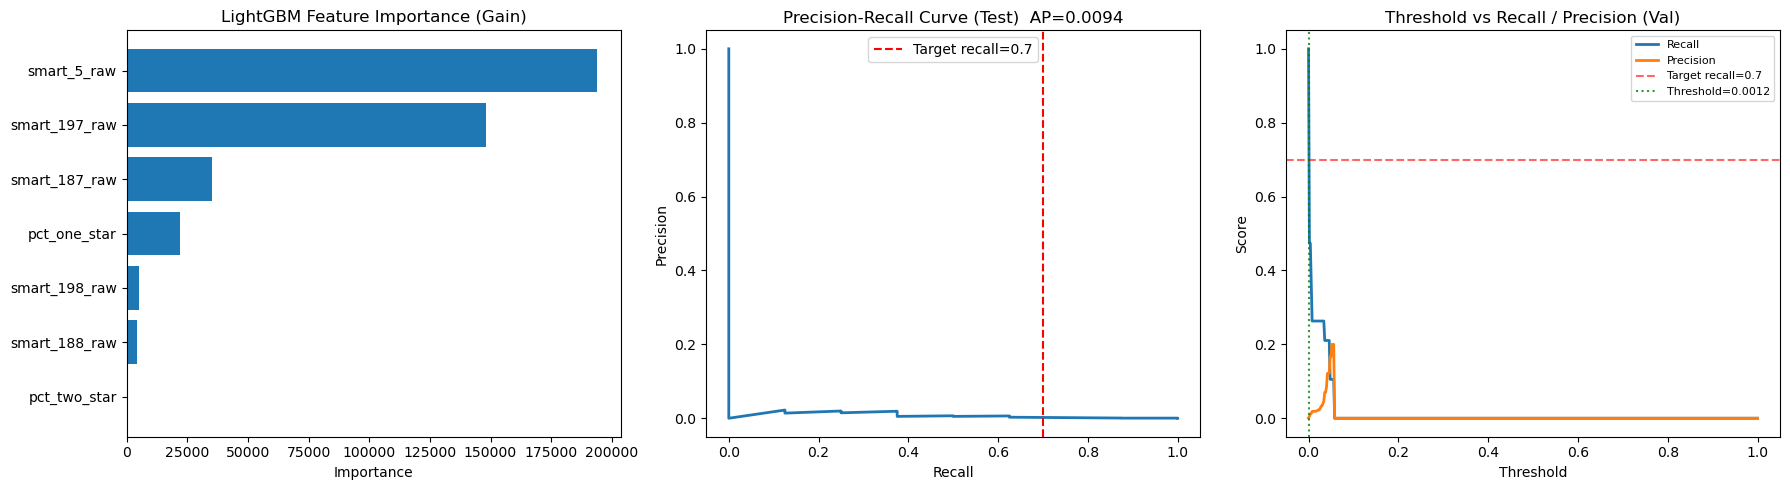


SUMMARY
  Decision threshold:    0.001209
  LightGBM best iter:   8
  scale_pos_weight:      51.1
  Target recall:         0.7


In [12]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score,
    precision_score, f1_score, roc_auc_score, precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt

# ── Feature / target setup ──────────────────────────────────────────────────
feature_cols = ['pct_one_star', 'pct_two_star', 'smart_5_raw',
                'smart_187_raw', 'smart_188_raw', 'smart_197_raw', 'smart_198_raw']

X_train = df_train[feature_cols].copy()
y_train = df_train['failure'].astype(int).copy()
X_val   = df_val[feature_cols].copy()
y_val   = df_val['failure'].astype(int).copy()
X_test  = df_test[feature_cols].copy()
y_test  = df_test['failure'].astype(int).copy()

n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos = np.sqrt(n_neg / n_pos)
print(f"Training positives: {n_pos}  negatives: {n_neg}")
print(f"scale_pos_weight (sqrt-dampened): {scale_pos:.1f}")

# ── Train LightGBM ──────────────────────────────────────────────────────────
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)

params = {
    'objective':         'binary',
    'metric':            'auc',            # early-stop on AUC (not logloss)
    'boosting_type':     'gbdt',
    'scale_pos_weight':  scale_pos,
    'learning_rate':     0.01,
    'num_leaves':        15,
    'max_depth':         4,
    'min_child_samples': 10,
    'min_child_weight':  1e-3,
    'subsample':         0.7,
    'colsample_bytree':  0.7,
    'reg_alpha':         1.0,
    'reg_lambda':        5.0,
    'max_bin':           127,
    'verbose':           -1,
    'seed':              42,
    'force_row_wise':    True,
}

callbacks = [
    lgb.early_stopping(stopping_rounds=300),
    lgb.log_evaluation(period=200),
]

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=3000,
    valid_sets=[lgb_val],
    valid_names=['val'],
    callbacks=callbacks,
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best val AUC:   {model.best_score['val']['auc']:.4f}")

# ── Threshold tuning on VALIDATION set  (target recall ≥ 0.70) ─────────────
y_val_prob = model.predict(X_val, num_iteration=model.best_iteration)

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_prob)

TARGET_RECALL = 0.70

# Build candidate list: (precision, recall, threshold, fp_count)
candidates = []
for p, r, t in zip(precisions[:-1], recalls[:-1], thresholds):
    if r >= TARGET_RECALL:
        y_pred_tmp = (y_val_prob >= t).astype(int)
        fp_count = ((y_pred_tmp == 1) & (y_val == 0)).sum()
        candidates.append((p, r, t, fp_count))

if candidates:
    # Primary sort: fewest false positives (ascending), tiebreak by recall desc
    candidates.sort(key=lambda x: (x[3], -x[1]))
    best_prec, best_rec, best_thresh, best_fp = candidates[0]
    print(f"\nOptimal threshold on validation set: {best_thresh:.6f}")
    print(f"  -> Val Precision: {best_prec:.4f}   Val Recall: {best_rec:.4f}   Val FP: {best_fp}")
else:
    # fallback: closest to target recall
    idx = np.argmin(np.abs(recalls[:-1] - TARGET_RECALL))
    best_thresh = thresholds[idx]
    best_rec = recalls[idx]
    best_prec = precisions[idx]
    print(f"\nCould not reach {TARGET_RECALL:.0%} recall; closest threshold: {best_thresh:.6f}")
    print(f"  -> Val Precision: {best_prec:.4f}   Val Recall: {best_rec:.4f}")

# ── Evaluate helper ─────────────────────────────────────────────────────────
def eval_set(name, y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    print(f"\n{'='*80}")
    print(f"{name} RESULTS  (threshold={threshold:.6f})")
    print(f"{'='*80}")
    print(classification_report(y_true, y_pred, digits=4,
                                target_names=['No Failure', 'Failure']))
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    tn, fp, fn, tp = cm.ravel()
    rec  = tp/(tp+fn) if (tp+fn) > 0 else float('nan')
    prec = tp/(tp+fp) if (tp+fp) > 0 else float('nan')
    fpr  = fp/(fp+tn) if (fp+tn) > 0 else float('nan')
    print(f"\n  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
    print(f"  Recall (positive):    {rec:.4f}")
    print(f"  Precision (positive): {prec:.4f}")
    print(f"  False-positive rate:  {fpr:.6f}  ({fp:,} false positives)")
    try:
        auc = roc_auc_score(y_true, y_prob)
        ap  = average_precision_score(y_true, y_prob)
        print(f"  ROC-AUC: {auc:.4f}   Average Precision: {ap:.4f}")
    except Exception:
        pass
    return cm

cm_val  = eval_set("VALIDATION",  y_val,  y_val_prob,  best_thresh)
cm_test = eval_set("TEST",        y_test, y_test_prob := model.predict(X_test, num_iteration=model.best_iteration), best_thresh)

X_prod = df_prod[feature_cols].copy()
y_prod = df_prod['failure'].astype(int).copy()
y_prod_prob = model.predict(X_prod, num_iteration=model.best_iteration)
cm_prod = eval_set("PRODUCTION",  y_prod, y_prod_prob, best_thresh)

# ── Plots ───────────────────────────────────────────────────────────────────
importance = model.feature_importance(importance_type='gain')
feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': importance})
feat_imp = feat_imp.sort_values('importance', ascending=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(feat_imp['feature'], feat_imp['importance'])
axes[0].set_title('LightGBM Feature Importance (Gain)')
axes[0].set_xlabel('Importance')

prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)
ap_test = average_precision_score(y_test, y_test_prob)
axes[1].plot(rec_t, prec_t, lw=2)
axes[1].axvline(x=TARGET_RECALL, color='r', linestyle='--', label=f'Target recall={TARGET_RECALL}')
axes[1].set_title(f'Precision-Recall Curve (Test)  AP={ap_test:.4f}')
axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
axes[1].legend()

thresholds_plot = np.linspace(0, 1, 500)
rec_plot  = [recall_score(y_val, (y_val_prob >= t).astype(int), zero_division=0) for t in thresholds_plot]
prec_plot = [precision_score(y_val, (y_val_prob >= t).astype(int), zero_division=0) for t in thresholds_plot]
axes[2].plot(thresholds_plot, rec_plot, label='Recall', lw=2)
axes[2].plot(thresholds_plot, prec_plot, label='Precision', lw=2)
axes[2].axhline(y=TARGET_RECALL, color='r', linestyle='--', alpha=0.6, label=f'Target recall={TARGET_RECALL}')
axes[2].axvline(x=best_thresh, color='green', linestyle=':', alpha=0.8, label=f'Threshold={best_thresh:.4f}')
axes[2].set_title('Threshold vs Recall / Precision (Val)')
axes[2].set_xlabel('Threshold'); axes[2].set_ylabel('Score')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}")
print(f"  Decision threshold:    {best_thresh:.6f}")
print(f"  LightGBM best iter:   {model.best_iteration}")
print(f"  scale_pos_weight:      {scale_pos:.1f}")
print(f"  Target recall:         {TARGET_RECALL}")